In [5]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import json
from ast import literal_eval
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

from six.moves import cPickle
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.layers import Add, Activation, Lambda, Input, Reshape, Dot
from keras.regularizers import l2
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping

#from mpl_toolkits.basemap import Basemap
import plotly.express as px
from IPython.core.display import display,HTML

from ast import literal_eval

%matplotlib inline

In [8]:
# Creating a function to read the json file and turning it into a dataframe
def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file,encoding="utf8") as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [9]:
# Reading the json files
users  =read_json("data/yelp_academic_dataset_user.json")
reviews = read_json('data/yelp_academic_dataset_review.json')
business = read_json('data/yelp_academic_dataset_business.json')

In [10]:
#Creating copies of the original dataset to prevent reloading of data
users_=users.copy()
reviews_=reviews.copy()
business_=business.copy()

In [11]:
# Taking a peek into the business dataset column types  
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


Looking at the dataset, we can see that there are three main columns, namely attributes, categories and hours that contain null values that need to be taken care of. <br>
Lets drop the businesses that are no longer open as they would not be useful in restaurant recommender and then have a look at the number of null data values we have in the three columns stated previously.

In [12]:
#Dropping businesses that are not open
business = business[business['is_open']==1]

Considering that we require only restaurants that provide food, lets pick out only the relevant businesses.

In [13]:
# Taking a subset of the dataframe
business_restaurant = business[business['categories'].str.contains('Restaurants') & business['categories'].str.contains('Food')]

In [14]:
# Taking a look at the dataset following the check-clean-check policy
business_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17732 entries, 8 to 209390
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   17732 non-null  object 
 1   name          17732 non-null  object 
 2   address       17732 non-null  object 
 3   city          17732 non-null  object 
 4   state         17732 non-null  object 
 5   postal_code   17732 non-null  object 
 6   latitude      17732 non-null  float64
 7   longitude     17732 non-null  float64
 8   stars         17732 non-null  float64
 9   review_count  17732 non-null  int64  
 10  is_open       17732 non-null  int64  
 11  attributes    17326 non-null  object 
 12  categories    17732 non-null  object 
 13  hours         15650 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 2.0+ MB


Here we see that there are 2082 null values for hours and 406 null values for attributes.We will be taking care of them at a later point. 

Lets perform EDA to better understand our data prior to cleaning

Getting the distribution of ratings to have a rough estimate of the most likely value

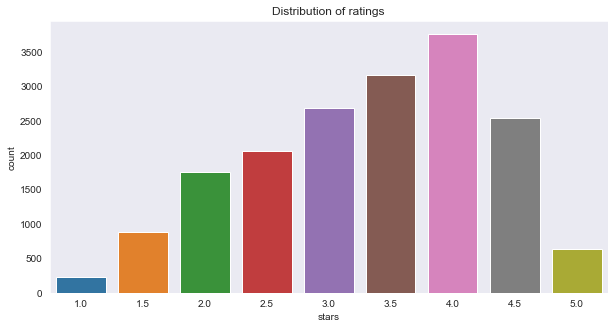

In [99]:
plt.figure(figsize=(10,5))
sns.countplot(business_restaurant.stars)
plt.title("Distribution of ratings")
plt.show()

Looks like most customers are generally pleased with the restaurant they choose to go to. Perhaps not too many users try new cuisines and restaurants. 
Lets now have a look at the distribution of restaurants taking the top 10 restaurants

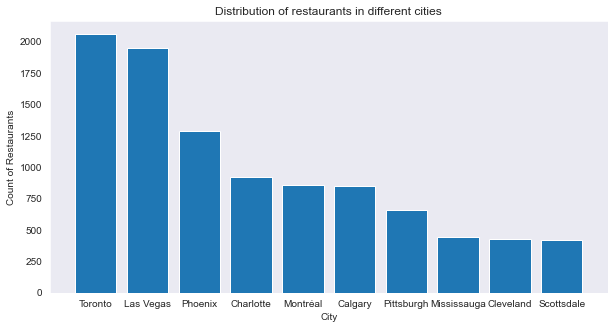

In [109]:
plt.figure(figsize=(10,5))
plt.bar(business_restaurant.city.value_counts()[:10].index, business_restaurant.city.value_counts()[:10].values)
plt.title("Distribution of restaurants in different cities")
plt.xlabel("City")
plt.ylabel("Count of Restaurants")
plt.show()

Toronto seems to be a restaurant hub, but Las Vegas is not too far behind.

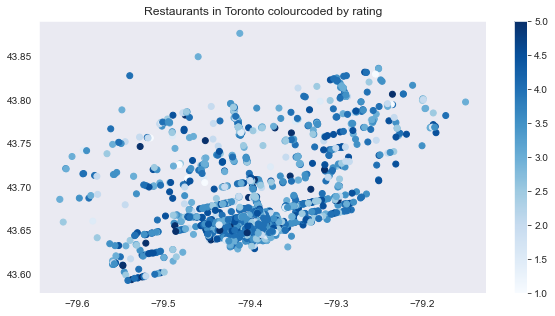

In [101]:
plt.figure(figsize=(10,5))
plt.scatter(business_restaurant[business_restaurant.city=="Toronto"].longitude, business_restaurant[business_restaurant.city=="Toronto"].latitude, c=business_restaurant[business_restaurant.city=="Toronto"].stars, cmap="Blues", )
plt.title("Restaurants in Toronto colourcoded by rating")
plt.colorbar()
plt.show()

As we can see from this graph, there is a higher density of restaurants along the coast and most of them seems to have a rating higher than 3.

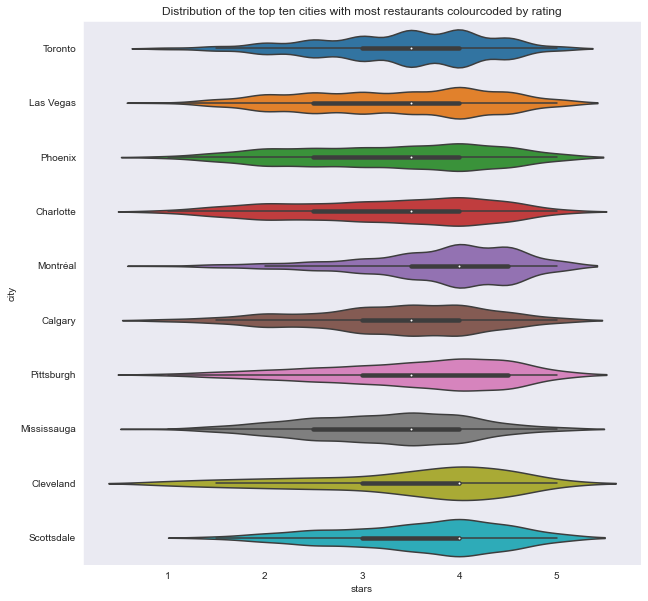

In [177]:
# Getting the top 10 cities to plot their distribution
plt.figure(figsize=(10,10))
top_cities=business_restaurant.city.value_counts()[:10].index
empty_df=pd.DataFrame()
for i in top_cities:
    empty_df=pd.concat([empty_df,business_restaurant[business_restaurant['city']==i][['city','stars']]],axis=0,ignore_index=True)
sns.violinplot(y='city',x='stars',data=empty_df)
plt.title("Distribution of the top ten cities with most restaurants colourcoded by rating")
plt.show()

Here we can see that there are high number of restaurants in Toronto however, the quality of the restaurants are not as good as Montreal where the distribution of stars are more skewed toward a higher rating.

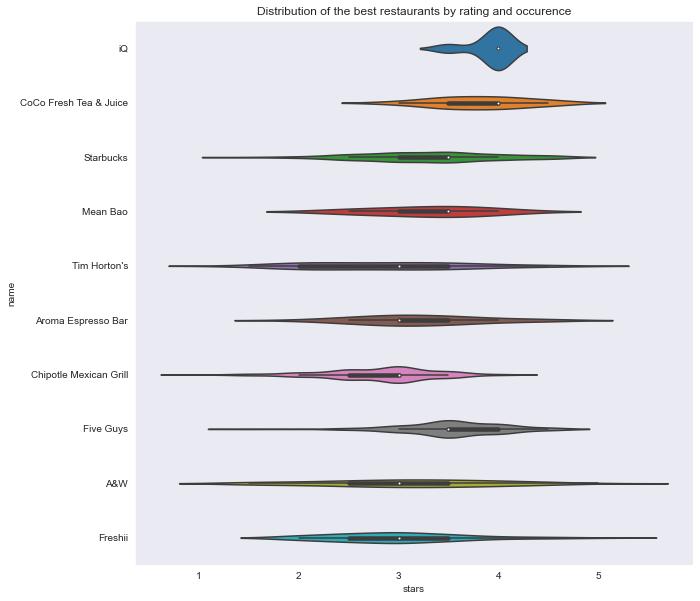

In [197]:
most_occur_rest=business_restaurant[business_restaurant['city']=='Toronto'].name.value_counts()[:25].index

df_occur=pd.DataFrame()
for i in most_occur_rest:
    df_occur=pd.concat([df_occur,business_restaurant[business_restaurant['name']==i][['name','stars','city']]],axis=0,ignore_index=True)
    
    
top_rest = df_occur[df_occur['city']=='Toronto'].groupby('name')['stars'].mean().sort_values(ascending=False).index[:10]
plt.figure(figsize=(10,10))
empty_df=pd.DataFrame()
for i in top_rest:
    empty_df=pd.concat([empty_df,df_occur[df_occur['name']==i][['name','stars']]],axis=0,ignore_index=True)
sns.violinplot(y='name',x='stars',data=empty_df)
plt.title("Distribution of the best restaurants by rating and occurence")
plt.show()


Here we see that very few restaurants that have many visitors have a low standard deviation around the mean value. This would indicate the varied taste of visitors.

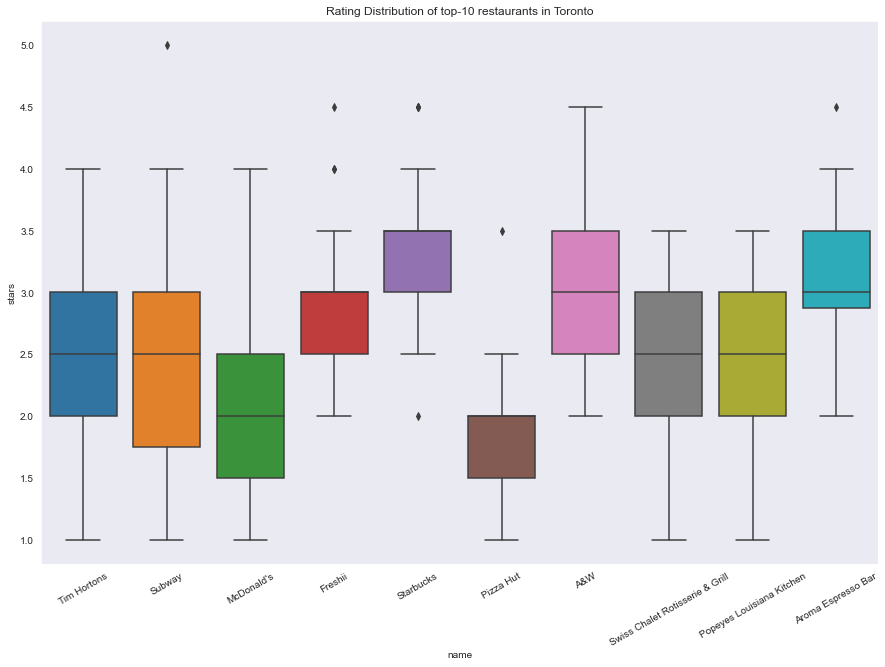

In [198]:
toronto_df = business_restaurant[business_restaurant['city']=='Toronto']
plt.figure(figsize=(15,10))
sns.boxplot(x = 'name', y = 'stars', data = toronto_df[toronto_df.name.isin(toronto_df.name.value_counts().sort_values(ascending = False)[:10].index)])
plt.xticks(rotation=30)
plt.title("Rating Distribution of top-10 restaurants in Toronto")
plt.show()

Lets now take care of the NaN values of the dataframe

In [15]:
# Taking a subset of the dataframe
review_restaurant = reviews[reviews.business_id.isin(business_restaurant['business_id'].values)]
user_restaurant = users[users.user_id.isin(review_restaurant['user_id'].values)]

In [16]:
# Expanding the values of the 'categories' column
business_restaurant.categories = business_restaurant.categories.str.split(',').apply(lambda x: list(map(str.strip, x)))

# Getting the dummy variables
dum = pd.get_dummies(business_restaurant.categories.apply(pd.Series).stack()).sum(level=0)
business_restaurant.drop("categories", axis=1, inplace=True)
business_restaurant_one_hot = pd.concat([business_restaurant, dum], axis=1)

We have now taken care of the missing values in the catgories column and formatted it to be fed into a model. Let us now look at the attributes column to take care of the missing values.

The concept behind taking care of the missing values is as follows:
- Find the most occurring value for each attribute
- Replace the NaN's with all the attributes and their most common value if the attribute occurs more than 500 times in the dataset

In [17]:
#Creating a dictionary to store the count for the each attribute value
tmp_dic=dict()
for i in business_restaurant['attributes'].tolist():
    #Checking if there is an attribute present
    if(i):  
        #Iterating through each attribute value pair and assigning a count for each attribute value pair
        for j,k in i.items():
            #Checking that the attribute value is not NaN
            if(k):
                if(j in tmp_dic.keys()):
                    if k in tmp_dic[j].keys():
                        tmp_dic[j][k]+=1
                    else:
                        tmp_dic[j][k]=0
                else:
                    tmp_dic[j]={k:0}

In [18]:
# Getting a dictionary that will replace the nan values with the most occuring value for each attribute
fill=dict()
for i,j in tmp_dic.items():
    counts=list(j.values())
    if(max(counts)>500):
        most_common=list(j.keys())[counts.index(max(counts))]
        fill[i]=most_common

In [19]:
# Replacing the nan values
business_rest=[]
for i in business_restaurant['attributes'].tolist():
    #Checking if there is an attribute present
    if(i): 
        business_rest.append(i)
    else: 
        business_rest.append(fill)

In [20]:
# Bringing everything together
business_restaurant = pd.concat([business_restaurant_one_hot.reset_index(drop=True), pd.DataFrame(business_rest)], axis=1)

Let us now check our dataset

In [21]:
business_restaurant.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,BestNights,Music,Corkage,BYOB,BYOBCorkage,DietaryRestrictions,AgesAllowed,Open24Hours,AcceptsInsurance,RestaurantsCounterService
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,404 E Green St,Champaign,IL,61820,40.110446,-88.233073,4.5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,300 John Street,Thornhill,ON,L3T 5W4,43.820492,-79.398466,4.5,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tLpkSwdtqqoXwU0JAGnApw,Wendy's,4602 Northfield Road,Cleveland,OH,44128,41.434614,-81.527026,3.5,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,lK-wuiq8b1TuU7bfbQZgsg,Hingetown,,Cleveland,OH,44113,41.489343,-81.711029,3.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now have NaN values due to the one hot encoding. Let us leave these values as is. However when we look at tmp_dic which stores the count of each attribute, we can see that there are a few columns that have dictionaries in them. Lets one hot encode these.

In [22]:
#Function to convert strings withing a column to a dictionary
def f(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        return None

In [23]:
# Columns that require further one hot encoding
cols=['BusinessParking','Ambience','GoodForMeal','BestNights','Music','DietaryRestrictions']
for i in cols:
    #Getting the flattened dataframe for the column
    df=business_restaurant[i].apply(lambda x: f(x)).apply(pd.Series)
    business_restaurant=pd.concat([business_restaurant,df],axis=1)
    business_restaurant.drop(i,axis=1,inplace=True)

Now we take care of the NaN values present in hours. 
The concept behind the replacing of values is as follows:
- Take the most occuring value of the opening and closing times for each day over all restaurants 
- Use these most occuring values to replace NaN's

We format the hours column and expand it to give opening and closing hours per day as separate columns. No Nan values are taken care of just yet.

In [204]:
#New dataframe to store the opening and closing hours per day
df_tmp=pd.DataFrame(index=range(len(business_restaurant)),
                    columns=['Monday_open','Monday_close',
                          'Tuesday_open','Tuesday_close',
                          'Wednesday_open','Wednesday_close',
                          'Thursday_open','Thursday_close',
                          'Friday_open','Friday_close',
                          'Saturday_open','Saturday_close',
                          'Sunday_open','Sunday_close'])

for count,i in enumerate(business_restaurant['hours'].tolist()):
    #Checking if there are timings present
    if(i):  
        #Iterating through day and open hours 
        for j,k in i.items():     
            #Checking that the hour is not NaN
            if(k):
                #Time of opening
                t_open=k.split('-')[0]
                #Time of closing
                t_close=k.split('-')[1]
                
                t_open_hr= int(t_open.split(':')[0])
                t_close_hr= int(t_close.split(':')[0])
                
                df_tmp[j+'_open'][count]=t_open_hr
                df_tmp[j+'_close'][count]=t_close_hr
                

In [206]:
# Taking a look at the temporary dataframe
df_tmp.head()

,Monday_open,Monday_close,Tuesday_open,Tuesday_close,Wednesday_open,Wednesday_close,Thursday_open,Thursday_close,Friday_open,Friday_close,Saturday_open,Saturday_close,Sunday_open,Sunday_close
0,11,14,11,14,11,14,11,14,11,14,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,21,10,21,10,21,10,21,10,21,10,21,11,18
3,10,3,10,3,10,3,10,3,10,3,10,3,10,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let us now take care of the NaN rows

In [207]:
# Finding the most occuring value for each column
most_occuring=df_tmp.mode()

# Replacing the NaN values with their respective most frequent value
for i in df_tmp.columns:
    df_tmp[i]=df_tmp[i].fillna(most_occuring[i].values[0])

In [208]:
# Concatenating the dataframes
business_restaurant=pd.concat([business_restaurant,df_tmp],axis=1)

In [28]:
# Dropping the unnecessary columns
vars_to_drop = ['state','postal_code','address', 'hours', 'attributes']
restaurants_final = business_restaurant.drop(vars_to_drop, axis=1)
# Saving the final restaurants dataframe
restaurants_final.to_csv('data/restaurants_final.csv')

In [29]:
restaurants_final.head()

,business_id,name,city,latitude,longitude,stars,review_count,is_open,& Probates,Acai Bowls,...,Wednesday_open,Wednesday_close,Thursday_open,Thursday_close,Friday_open,Friday_close,Saturday_open,Saturday_close,Sunday_open,Sunday_close
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,40.110446,-88.233073,4.5,5,1,0,0,...,11,14,11,14,11,14,11,22,11,22
1,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,Thornhill,43.820492,-79.398466,4.5,7,1,0,0,...,11,22,11,22,11,22,11,22,11,22
2,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,33.602822,-111.983533,4.0,10,1,0,0,...,10,21,10,21,10,21,10,21,11,18
3,tLpkSwdtqqoXwU0JAGnApw,Wendy's,Cleveland,41.434614,-81.527026,3.5,7,1,0,0,...,10,3,10,3,10,3,10,3,10,3
4,lK-wuiq8b1TuU7bfbQZgsg,Hingetown,Cleveland,41.489343,-81.711029,3.0,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Lets take a look at the dataframe report

In [30]:
def pretty_print(df):
    return display(HTML( df.to_html().replace('\\n', '<br>')))

def table_report(tbl, cols=None, card=20):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    #print(dtypes)
    nulls = []
    uniques = []
    numuniques = []
    vcs=[]
    for col in tbl.columns:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card:
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join("{}:{}".format(k,v) for k, v in valcounts.items())
        else:
            vc = 'NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

In [31]:
table_report(restaurants_final)

Table Shape (17732, 659)


,dtype,nulls,uniques,num_uniques,value_counts
business_id,object,0,"[pQeaRpvuhoEqudo3uymHIQ, lu7vtrp_bE9PnxWfA8g4Pg, vjTVxnsQEZ34XjYNS-XUpA, tLpkSwdtqqoXwU0JAGnApw, lK-wuiq8b1TuU7bfbQZgsg, LAoSegVNU4wx4GTA8reB6A, OWkS1FXNJbozn-qPg3LWxg, j9bWpCRwpDVfwVT_V85qeA, MTx-Zdl_KcU_z9G832XAjg, 8nP8ghEpT6WFcM6tfqAaGA, 8k62wYhDVq1-652YbJi5eg, 8Hvp1tYKiQbBgGIwkCRK5g, OGVHlFHSXjHuioOvm1wVqg, 34FYKG4pHNXbM9ZRRiJaGw, 3C0bnFhjkgYP9mWORKg6cA, TN4rJ96kZ99k_zSI2yuPbA, 0DnQh8SE8BSnvJltGCCiWg, NLaK58WvlNQdUunSIkt-jA, 5X7TQsA3iDbBc8yy2YkCnA, VBVqHnViRLSYAqP7v8iNNQ, 0nqQIM2PvOcTX6v0L537_Q, VCkKTkLWh9dY5vSdNPZDqw, AtD6B83S4Mbmq0t7iDnUVA, TKKX9bllRBMzp0NYr441PQ, ypILNgy7QFskKAdcPKB2RQ, 2nbibYLTR96Nr2nk-1spdw, bjqwzEr9fU1keOcJFOZqWA, CfwrsG76Wm4iLS22v_wAcg, _V4CzzA7Z9h4qyLIdG-KUg, grZ6FnfZoj1pQWElAQve3g, oUX2bYbqjqST-urKbOHG6w, FiW6w5nmhlUoJAyNofb4jg, K4rLi2Mqz931v07nMSih5w, CU4LgHxH0EwXnPUmQsWFSQ, 0W27hbZN7Z-PrkhAb0y9Eg, Rtaca3VZIioxy6N006NKaQ, dfqLhdQY9e6EiXMk9t-8WQ, eKbN4KVQYgGt3flbYqfXzw, UhgNf97gZW2gbMtVodBh9g, zrnP9HqoF-RI9jqoW8pytA, owV0aSgh4t_9aG56iPxGEw, c1JoHp602zilpDU_57DsMg, Iq1P8S3--gqd50xoQJxpqA, 5gl2GLgimBz1-Q-uXji_Rw, IjYGSm4_DjP6VULpP27o_g, vsGoYMRvBYss3x9fn-jDzQ, JOtv0NcBkvd9RO_D9cM3Qg, -QC71Wuh0TyJI0RAZ3d0Iw, WUmosjOxt_8nWByHgm8Kkg, sAEFh7e7fY-W2gMWSbIAWQ, FoZQW4WpXAEOOVZ9MepnZA, _8I19IRzDXmMSRES9cEGlw, Wxt77slJbuwQ3LDbfrBkzQ, 8XVAcOZ02IGTQE-pvKhXXw, ijNQXC2cBhbkf6iB6D8OJw, UkBy7Epd2q6YXZhYas8iEA, f1L-fI_wM5aH7_YG7WcUaA, ITc7sL3YYxHoQYoPNNH_GA, lCwUmc0IEhIMz7lyZ2nwuA, nvh-zGYHKwIUiPTgwhIScA, MM572Htt9k_e96IKNyCEtA, P6fzFH0yXmfzepXJTnRldQ, v3kXkK9ga8jfgetr0Hb5Eg, T0NKethAB-FFR05EeZCzuA, DloBjCZHlz0lzsrQJq5PHQ, g2Y2lnMmnOouvivEie9myw, sphMzEIqY1I2Dzv3zLZY2g, 6pGzbQQwGdqKbXGdaTNy5A, DEtOIjhV0MWZ8fD8-YZCww, crOZthKtsABnH_nvy0w6YA, QHRF1RvAmZIbnXWK_fCPcQ, EMmCHg3Fgk9jZrHVB8OJXw, aSn4fgpq-3FDfvVG2bjv3A, iiOpaR1Am7svS0SF_eBoOQ, JGbQOdAAqxEKlyJy07omuw, kUPlKgW6OLRw8_rrYtBV3A, FHCNPBORRJ6gvNf3xBtnBA, dgV3b_HRCGcrR1-OzkwHNA, du9_QFb75sxzKnLLQwSkMw, Dz5cc8BKyHc_8pUTxbCXkA, SUaEbsKFSo33idJzQ9Dfjw, Yq0LCrGLjJtKcwBu1Nta6w, pUUb-AOxcwHJutHnsHwPsg, NtfAbj7MSj5IOhAsGM0-5w, EaPIQm6ULaHkB4hcrfFWwA, G5YM5jbCTAFE2IDGNRjYnQ, x1Cd2gSPZVeNxDPzzqlClQ, 9j4nk2WOT6XCDRgX-lGzVA, AVsZE_gMkuBmRLRiqmPqJQ, 67ebdi7bAH6YDfnNHL8xYw, i4ZLquZaqB7dCu4P6gHGDQ, TSReAmFxNVCZggcx49Gf3A, qUkd14n2uMXEboKOwYw8uQ, Lij0OcvPD4LAnmklHQpDCg, gc2XZigymAwwNkjihdkO5w, PrFfdw7WuGAnrkyAIzX65g, niqIaJy9UXu-DS7BIUvUoA, sVK1Rrpu5zGGdj_Gh2aaZA, Zpydi0JmOp3XXL5hDGALXg, eRZuxjnaMviiVyvhejwTBQ, ...]",17732,NA
name,object,0,"[The Empanadas House, Banzai Sushi, Wetzel's Pretzels, Wendy's, Hingetown, Tzikii Food Truck, Mama Napoli Pizza, Papaya Thai, Taco Bell, Sugar Bowl, Tim Hortons, Tony's Family Restaurant, The Jackman Bar & Restaurant, Chili Man, Fromagerie Des Nations, Chick-N-Joy, Zav Coffee Shop & Gallery, Blimpie, Jalapeño Inferno, Fearless Meat, Mrakovic Meat & Deli, Veggie House, Mi'Hito Sushi Laboratory, KFC, Church's Chicken, Chinese New Year Celebration, McDonald's, Loftti Cafe, Fruits and Roots, Chipotle Mexican Grill, B Montréal, Sonic Drive-In, Martins, Café dei Campi, Mister Chang's Coffee House, Mlle Catherine, Panda Express, Starbucks, Blended, Milano's Pizza & Pasta, My Roti Place, Hef's Bar & Grill, Legacy Cafe And Lounge, MAD Greens - Scottsdale, Switchin' Kitchens, Little Caesars Pizza, Ricky's All Day Grill, Plentea, Genoa Pizza & Bar, A&W, Campus Commons Food Court, Piccolo Pizza N Ice, Heart Clean Eats, stonegrill, The Dumpling Hero, Burger King, The Lit Grille, Global Restaurant, Carl's Jr of Las Vegas, Whole Grain Natural Bread, Irie Vibes Caribbean Restaurant & Catering, Pita Land, Davis Bakery & Delicatessen, Mama's Pizza & Pasta, Civic Market, Seaboard Brewing, Tap Room & Wine Bar, Firehouse Subs, Five Guys, Lake Norman Cottage, Sidelines Beer House, Juice Core, Einstein Bros Bagels, Smoke’s Poutinerie, La Herradero 2, Casey's General Store, Fritou Chicken, City Cafe, JJ's Grubb Shack N Liquor, Yogi's Noodles, Rally's, Swiss Chalet Rotisserie & Grill, Pagoda, DeCourse

We are now done with the restaurants dataframe, let us clean the reviews dataframe

In [32]:
review_restaurant.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57
5,L2O_INwlrRuoX05KSjc4eg,5vD2kmE25YBrbayKhykNxQ,nlxHRv1zXGT0c0K51q3jDg,5.0,2,0,0,This is definitely my favorite fast food sub s...,2013-05-07 07:25:25
11,Tyx7AxYQfSRnBFUIXUJwFA,HJECayULRM-6xh2GCCvLiA,l-nL4BmhzpZjcavooO48PQ,4.0,2,1,1,ORDER In (Delivery) Review\n\nI discovered thi...,2015-10-17 01:38:13
22,sgTnHfeaEvyOoWX4TCgkuQ,A0j21z2Q1HGic7jW6e9h7A,9Jo1pu0y2zU6ktiwQm6gNA,4.0,24,19,20,"Coconut's Fish Cafe is a fantastic, Five Stars...",2016-12-04 03:15:21
28,K-wdPGHbErfxbKK6PetrmA,FCoXqPxuI7GRBYyzJIwVxw,r4HkiC71nB9k8Fe8zIORFQ,5.0,1,0,1,First time eating there and everything was so ...,2015-12-05 02:16:06


In [33]:
review_restaurant.isna().any()

review_id      False
user_id        False
business_id    False
stars          False
useful         False
funny          False
cool           False
text           False
date           False
dtype: bool

Here we can see that there are no NaN values to take care of. Let us format the date column to the required format.

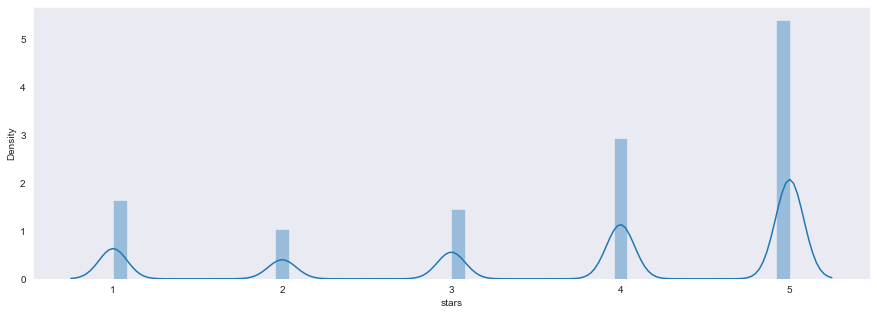

In [219]:
plt.figure(figsize=(15,5))
sns.distplot(review_restaurant.stars)
ax.set_title("Plotting the distribution of the reviews of users")
plt.show()

Looks like the users on yelp are very generous. Most of the users have given high ratings to restaurants.

In [34]:
# Type-casting the 'date' column
review_restaurant.date = review_restaurant.date.astype('datetime64[ns]')

# Getting features out of the 'date' column
review_restaurant['review_year'] = review_restaurant['date'].dt.year
review_restaurant['review_month'] = review_restaurant['date'].dt.month
review_restaurant['review_weekday'] = review_restaurant['date'].dt.weekday

# Dropping the unnecessary columns
cols_to_drop = ['text', 'date']
review_restaurant.drop(cols_to_drop, axis=1, inplace=True)

In [35]:
# Saving the final review dataframe
review_restaurant.to_csv('data/review_final.csv', index = False)

Getting a report of the reviews dataframe

In [36]:
table_report(review_restaurant)

Table Shape (1436131, 10)


,dtype,nulls,uniques,num_uniques,value_counts
review_id,object,0,"[6TdNDKywdbjoTkizeMce8A, L2O_INwlrRuoX05KSjc4eg, Tyx7AxYQfSRnBFUIXUJwFA, sgTnHfeaEvyOoWX4TCgkuQ, K-wdPGHbErfxbKK6PetrmA, PTk6YHmk2U7X-A7Js-VtNA, 2mLlQ9n5Ln_fykOuX_b0-A, -cRD6URpwks2GvP6qy8x4Q, Ymb8ZYPg2e8dvqhdj3Gkqw, o3kyWgk5ZMW1KlLw6-tv2g, nAm92_-WUQ084x9Uz9iFmA, a9bcki-Jt26TtUoNRGjQHg, 8qdikDQ0bkJj7QZa2IdvrQ, slmv7dEs9FD3KsdbywTHUw, IwlVSOnINIYnqRBjPrRDhQ, 3ED-N6Nn3DE2cLfXZtGbjQ, 5rY_i4Eao9ncLmzvF_JNYg, E5iXQGD_x_Fyee1kOKgGTw, MRPCm_BYEHl2T9oNZYnCbQ, ydmLJUsQTKrUMmM1hSFjFg, 5n7Ye0F9mS7r25rnRfPhZw, c9VFCK3gXuNRvbC7lXfk1Q, WEw6ymSk3N0LY4xLpvLWZg, SmbjoJCoTvY24FhVACTyfg, Lx-ervsT1BqUL7OfW-Lb9A, Bkn84S917TNvyReOrzM_bw, as3dFVDDw_XHDtp749rWmw, saJUbTtnictm8KFx6cNNJA, IBXGhyjpKjAwfNpyrrltXg, iUFvcJ1ANyrfE_KasHUdRg, UqskD2QVe53bT47CDaJkFQ, jdeXUl1zbo8Vsf0TENrYVA, firvmOGi0dgeACCEV5luVw, fKRA1n-ngUIl9I8dmn5OpQ, xBe7qY1vyfeVpPVTfnulEg, EDQpLLFiAxeSxWI5ipwzBQ, UP5ZPaGL3ymPsfXMOgvyTg, rtNAgwpp5p2z238Sggc2YQ, PhN14AYrE5NgFKS3U8BZ1w, sLbCQgT1ZJWB0e-XOVyS2g, wHrbQBt0eSaQl0T3xjGhww, CX77JmILKKFTe5DLl8hHLA, bx69Dn6x1as5oLwARPf6Vg, gNIj56ZbIK15L_TFcO2Vag, sVo9gOvDzUj54CFKA0QiRQ, 7KtMOcDTthAvo5hTwkSCmA, dsnCj_jbRNBuzRFygt6fQA, tIIdt06cSPmn7RVPPpAbIg, KOZgFxzMJi_Qk5Y9gIOngw, rzP-DWDnEHQyBLqKQ0ifJw, uN3_j5Yu4xOeM05KkedRFg, ObO1y1Ffs6f3JtSSGA0rWQ, c2mdmZLsrXCfZpIGcqPOBQ, cECSlJT39-IbPBK-xfXfSA, e5VhPI_obVivFxvGE80KUg, PiqvgR0Psc-GBg9zEYcWbg, maVwPKGzHyX0tkKKlmjxpg, -DQb3fBYScdqyi_9irsJtA, SEs6ULw_3HPcnFs0g4ZsYw, W4z6w4jGiVb8ZlntHjYieg, Kg5ncegiJ3utWRxDtDpi8g, iua9qOmDKuhtMMWePtZ4Gg, 0Zl4FlQNr2SNYdTSL-I_BQ, 2H6BBloSKumJ5JWx3vzzjw, I5vhFnQIH7u1tWbkhf-eLA, nJAmCEu4TUprWUVHy59Hqg, jP4-vdi7Qv2-9kBN36SqRw, iZvHMdsGEO-bnrGzmG9K3Q, KbN5x32xhBxtD1LlTjc-LA, cAEzwo6ODchFpmOjMpQ6qg, MiBup120uHPaEXj4ZIe24A, tbX2a84nfzIfHcxuqymLbw, c4EOxDw7I0yO-YD6VCMBZQ, ispaSCkIdDh2QxvLYwwVTw, 0285zwocEL-GWL2l6fRd3w, T7UiE1ZvusDHGyhvBR7XYw, H1hdeQ1TdZ4fF1GctHWrfg, mmyTLeoDNbuZsKXRDy1www, eX_IxLVWmYbk-KOtunO-Zw, lr-I1KtY9_ivR1E28Z7Kkg, G-Mx9bsCsmIGICEtne17rw, mscF94aHl77US0MB1mrXvg, jIiulrIbZy1hQ3BjzaFEDQ, O5NpKOLzmSh5EdU0SZzhLg, PI7qabMkCf_kfJyIW3jLAw, FgXSF5w_OmaCJb27I1-5ow, LaK3nCJaH-f6rMf7DCjU8A, bKfoEaIWc5_NIV6MLMYRzg, E2ZujnfG-jn7e-IWAOBDpQ, asLnux3k2yqoVjcJcLuF0g, -T40W1TjG-hpbFQPE3exeQ, Bl0ro6Sv5sL8VusH3ND6ig, JrrTV0W0I1ghblJYSTZYTw, SkCsX9eyj-r4Hdw86dBOgQ, 7W19o1AOXyTfdY5ZP0XUBw, Isj61vRf47u1Yb59MlNBmg, DuX698FftQvW-cTY-Mq04Q, hdGYXYZU0Ku7MjW-nkRopg, u5hsxd2s74jm2B1uAVcq5w, aOiuIszcQDMoc1sugEwCVw, ...]",1436131,NA
user_id,object,0,"[UgMW8bLE0QMJDCkQ1Ax5Mg, 5vD2kmE25YBrbayKhykNxQ, HJECayULRM-6xh2GCCvLiA, A0j21z2Q1HGic7jW6e9h7A, FCoXqPxuI7GRBYyzJIwVxw, bVwp0gnz3YxpJqSfXZrONg, EZ6g9a17UdMjtR-wrZebmA, 6UR0kNe3C-ivlF2x1fPHNQ, hHFSpKcnDtJOs6M-JKFZ8Q, FmQxARdHGnkclvcVWGEAxw, iFEM16O5BeKvf_AHs6NzUQ, 4xIRICDNx33zPG-CYshTXQ, 7MXunAzrmnbBd0XQR33zaA, Ir__fU1m6dBqgTrP3aLP9A, dZxXGlJtNwr9pag5UXCa4A, lMIm1Ye7BeVE21xqlImqEw, wGiUu3rFw83EDj8bzMzsuQ, ffMc-TmUUhEbj5LLNILB4A, oAFF_A02Ws0mwH-lkbzyMQ, LPva2snYp0Fdu8Z1QIXLiA, AVxQMKJsNvyNPbCJsinvYA, oCFvgGH40QHc25qOUrpu3A, ekO1FoeD8c9uqIQokBLCSQ, fFFTeVrZfTWuvbJXNKb-vQ, IIE2OX5haarGNefY23R8BA, V_fSO8w2zoV6n7JCqM54oA, zzaq5Fn1U2Feut3dGxidNg, RRhco4irDXPk5EJmvuwr2w, 8mLXf-R5YEr2pLfVrfSd3g, wRbcBWdiyeCDUydcBQcYfg, odHJ5JAWEdes_HV8Q3BMKQ, SCe2nY8q7x1Lozwf4tqU3w, EJq7AwhAAeywvg_lAANYJQ, 8zUniV0wOwnyjRWpAL_E-w, 8p4JGNgZl705fByqyF6BrQ, SkueY7hVsyXmYItELoodGw, cGskg8zw1KuSkpdraZXm7Q, jHONHSh8BHkmDARrfcoCGg, lluNN1aQlFN7NQQ2BxFBUQ, I1mLZm-YSIarwaj0q9Njuw, TTemlnsYaGzVKwt0lFFsiA, nHc2XXcOLpeUH_mkgUeWDQ, tSf2SivaZbYNabDCyQv1Tw, XOYOtGcJaddJkeH4JygokA, VmYpF5C3GL-7wFnvOkhpvg, OYvKoFz583_Sdn4-UWhUqg, 6WmMHMBM4FLGyK98-reecA, HmWd_szFZbzOJNbvrDI4DA, BwwqlPVsJk1dbUyNwCWB7Q, oz5TP2PGGAHIy5G4ZmO9rQ, rKkpHJkJ27xOwnhy_bMkvA, Hc2tC2TDMD1wDjp8aCq7jA, -tQ3UVVdNBZBR_HOVFROzw, kmOvnwtroMBC8y9lOR29bg, TSThCn9RaHqYF1VknVTTRQ, NhMt8aBjpG6LgOjDRXivJg, kTi96LP1DxwlFTe9jqkayQ, CWenIpiWVvcBJPXFR5A6OQ, Yxf8BEKQUUJ4IdSgq56sWw, C7aIVNWsRtOnn6cGtc8WAA, 1Dul59QEe-Q-7OQHTLOptw, Rc5x6wqDTC1x-jn-8TSkLg, GAHpfnWFW

We are now done with the review dataframe, let us clean the user dataframe

In [37]:
user_restaurant.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,...,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,...,4,5,2,1,33,37,63,63,21,5
6,ttumcu6hWshk_EJVWrduDg,Stuart,12,2010-05-12 16:30:08,29,4,6,,"1pKOc55fFx09J5t2rPzTxw, HYpE14yYEKSgu3VNVzObHA...",0,...,0,0,0,0,2,3,0,0,0,1
7,f4_MRNHvN-yRn7EA8YWRxg,Jennifer,822,2011-01-17 00:18:23,4127,2446,2878,"2011,2012,2013,2014,2015,2016,2017,2018","c-Dja5bexzEWBufNsHfRrQ, 02HJNyOzzYXvEKVApJb8GQ...",137,...,81,62,35,24,193,541,623,623,293,172
8,UYACF30806j2mfbB5vdmJA,Justin,14,2007-07-24 23:55:21,68,21,34,,"YwaKGmRNnSa3R3N4Hf9jLw, v9YpDzYkJarRbzvVIY-63g...",4,...,3,0,0,0,3,4,0,0,2,1


In [38]:
user_restaurant.isna().any()

user_id               False
name                  False
review_count          False
yelping_since         False
useful                False
funny                 False
cool                  False
elite                 False
friends               False
fans                  False
average_stars         False
compliment_hot        False
compliment_more       False
compliment_profile    False
compliment_cute       False
compliment_list       False
compliment_note       False
compliment_plain      False
compliment_cool       False
compliment_funny      False
compliment_writer     False
compliment_photos     False
dtype: bool

Here we can see that there are no NaN values to take care of

In [39]:
# Dropping the unnecessary columns
cols_to_drop = ['name', 'friends', 'elite']
user_restaurant.drop(cols_to_drop, axis=1, inplace=True)

# Type-casting the 'yelping_since' column
user_restaurant.yelping_since.astype('datetime64');


In [40]:
# Saving the final user dataframe
user_restaurant.to_csv('data/user_final.csv', index = False)

Getting the report of the user restaurant dataframe

In [41]:
table_report(user_restaurant)

Table Shape (629577, 19)


,dtype,nulls,uniques,num_uniques,value_counts
user_id,object,0,"[ntlvfPzc8eglqvk92iDIAw, FOBRPlBHa3WPHFB5qYDlVg, ttumcu6hWshk_EJVWrduDg, f4_MRNHvN-yRn7EA8YWRxg, UYACF30806j2mfbB5vdmJA, QG13XBbgHWydzThRBGJtyw, f6YuZP6iennHFVlnFJOXLQ, I_6wY8_RsewziNnKhGZg4g, q-v8elVPvKz0KvK69QSj1Q, HwPGLzF_uXB3MF8bc5u5dg, 6bbHSJ0PrgSxh7e5nigKMw, 4VmuXuSRhv5UxYUy3tMpiQ, pVU2DdtBFppBAX5G5t3rcw, q6QdLxYENKbVSo29ED2-JA, cWw606W2PmcjTZrwLq8Hmg, e9nlgxYgKrhE4VkwOo0LyQ, PamWn4FZwRiCYMdTw4lhcw, qmcTQ4RSOnKqW5eqc1CEfw, Lwyjwmodkmw4b9axrMXXdg, 61JaBatv-BJkzYol-ejEAg, -28RqJIrddOj9hhMBnzaFA, EFM7rmwvSEUbEGMWSNCnhQ, dIIKEfOgo0KqUfGQvGikPg, q_QQ5kBBwlCcbL1s4NVK3g, -ySXNLiIspI4UC8Qn7xT3w, JnPIjvC0cmooNDfsa9BmXg, 37Hc8hr3cw0iHLoPzLK6Ow, Xq8WEoTqNVUlI0pmd9cLEw, 4SyBNegg-YH5iNTE-PpgAA, o-GAkbTTcHFY3KqVDCE8sA, E_9Ss4n6bVJmAe1Grc8-Bw, Jtq_pKd7GVbXvFY8YU8kmw, mAhty2OHDTtLm00quB5Xjw, fcNU65OaCj7slBJ60VSQgw, kxj7TPtJY2zbEjGV0PYfAA, 4mjnkd8oJVCfBKN3i4rB-g, 60RKNAZwY5EUooJf624aKw, hHFl9Z7OlAJuI9FDXz1MgA, 13m1o7XsVfSDESEPmkfXng, H0Dq_zK4Ceepkd1KdDK7BQ, Gzn_5ZjbrOylXBkxuySY6Q, wQKHAT2SvrFstHqS9Pio2g, 73eIxdBLLo1PqtBJlkuoXg, dcjjKj_nJ1KF-AycxWuO8Q, ox0DtIS-AzUiVeGFkIvlMQ, -6J2VjbeLWAHsyAB8VN7bA, b0fp-eS8_MKTg4tcZsCNqQ, HLaSqQMDVvlcFPGJL_kGCA, l8IP6fObyuueE0s1drIy8A, Vqgtngey014F0bqj71q0aw, xoZvMJPDW6Q9pDAXI0e_Ww, xzyJzjk5J5vweSJv27Jx5Q, fgwI3rYHOv1ipfVfCSx7pg, nOk5ERmYcHlJ9jff994VBQ, _m3SyztWE_ji0wLxsL2Ycg, sqJZt_Z144RWGk4bdKTpSw, opPpHVIp8SKHMJg3_y5Lew, zHseuNq_3b246ZgzcY8BXA, L1px4LQVX-zO8qw0grD1Ug, tFy8QQLH9z9wspHBB1fRiQ, B8c17RLH6AaglKN-jW4RwQ, 7qOk1bh79tEvdJ0qMu2KJQ, qCrAu3LAbj4zkDYVST2efQ, exeizgUKHDl926YLRS-5Mw, ofi1Wkt-vV1fREaQtiBfKg, cx-kUXWTf90AHoPcv25__Q, _b9CQb4fPUo0sM0tdmhq5A, zulBnf95Ji1_LAcQKyhi8w, S2IHE59Ms_5S1tAgpSCrSg, ZdYHJ-hctaaDeH1CpP7-EA, ra0_P5KKYwU-imAVu_NW6g, OPN-dDUBkH7uH-G8nOnskg, hCocva0XP__DKOCVjvaE3w, CvYFllSy1cTPQu5nVDi8ew, 4an_jbW1wyOt3GC4gk6GaQ, 8H-avt5aFIaD2mpcgXwr3g, kpSaMjMbMumIm0tKoMhkvg, Ldxzq9w2rU3Osg8QHakwww, 3z7E1Gg001_1YdZZYDnO2A, 8ZryN_S-n48g6rsa3W3QtQ, 1Xw0qrx8Oo0MXIrYY9eTJg, FfxnvrbwI40dUUqA63KqGw, sXLAy83l7EwdZjsYFbaq0A, BzRgNA4tGWr3NN__U-xInA, 13f_vtUZEmlzweL91bmVng, X24q82ujb__rrrC6ujxt5g, 2dl7lGBoYtH_05Nxw1lxvw, MXnFKkh6_9kq3bE4dJXVgA, VR4MbcQSG5ucVTyM7n7xjQ, 8hTXa7xbVCp7yznGMdFaRw, H9FnhuwhThIk7-alE-FdwA, sVv7LVfyyBwMzIFLjsLL8g, EwiO9-1FuAgYRGYxYp7NKA, HAv257_IVJnQT0ZIL8Nn-Q, FOqxbPyEEP5Yfu5Qiy_XUA, RJXWEWZS6ZYT6wJ_EOBf2Q, d6fQOiuzx4gymcCr3mHarQ, Plj80QUEDpIFyiceQI87Bw, 930YU51ZvuOQn4dWtZxj5A, kLspThXD2v59fLCyqTueKw, ...]",629577,NA
review_count,int64,0,"[553, 564, 12, 822, 14, 218, 5, 405, 666, 6, 15, 106, 193, 72, 11, 59, 57, 61, 283, 9, 76, 44, 2061, 1218, 202, 988, 495, 250, 236, 145, 117, 396, 883, 1204, 1399, 1247, 885, 226, 349, 412, 13, 155, 110, 38, 938, 328, 377, 179, 34, 546, 536, 263, 1847, 242, 799, 235, 1462, 264, 152, 431, 240, 612, 56, 17, 266, 97, 85, 23, 142, 101, 660, 2474, 373, 36, 535, 42, 1002, 164, 73, 260, 46, 305, 388, 70, 311, 699, 30, 846, 83, 722, 20, 898, 26, 31, 65, 816, 1241, 320, 353, 374, ...]",1836,NA
yelping_since,object,0,"[2007-07-06 03:27:11, 2008-04-28 01:29:25, 2010-05-12 16:30:08, 2011-01-17 00:18:23, 2007-07-24 23:55:21, 2007-06-04 00:14:10, 2008-08-10 12:57:20, 2010-08-05 18:42:29, 2009-05-19 01:42:25, 2009-01-02 19:09:32, 2011-04-04 01:57:51, 2008-10-26 03:13:07, 2008-08-20 18:15:01, 2009-06-07 18:23:36, 2011-09-19 17:50:11, 2011-03-01 23:50:42, 2010-06-11 22:47:43, 2008-07-23 05:22:20, 2010-08-03 18:22:32, 2010-09-20 05:46:09, 2010-06-27 18:46:51, 2010-03-05 04:40:37, 2007-08-10 19:01:51, 2005-03-14 20:26:35, 2008-08-25 16:16:13, 2009-02-09 16:14:29, 2008-03-03 04:57:05, 2011-02-13 21:31:11, 2010-02-27 19:10:02, 2009-12-31 00:51:15, 2007-11-08 01:20:56, 2007-07-25 22:13:51, 2008-10-04 15:03:28, 2007-07-08 16:56:40, 2008-08-04 03:29:54, 2008-11-27 02:24:47, 2010-02-01 18:42:17, 2010-04-21 17:18:21, 2008-01-28 06:42:53, 2008-07-12 01:36:42, 2010-12-15 15:53:40, 2010-07-22 17:45:29, 2007-04-29 16:05:31, 2008-06-10 22:52:44, 2009-10-15 16:29:11, 2007-10-25 00:49:24, 2008-04-01 20:02

In [42]:
%%time 

# Loading the final dataframes
user_final = pd.read_csv('data/user_final.csv')
restaurant_final = pd.read_csv('data/restaurants_final.csv')
review_final = pd.read_csv('data/review_final.csv')

Wall time: 5.27 s


In [43]:
# Merging the three final dataframes
reviews_merged = review_final.merge(restaurant_final, on = 'business_id')
reviews_merged = reviews_merged.merge(user_final, on = 'user_id')
reviews_merged.head()

,review_id,user_id,business_id,stars_x,useful_x,funny_x,cool_x,review_year,review_month,review_weekday,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,2017,1,5,...,2,0,0,1,10,14,16,16,3,11
1,iSTtvMmoHCdKL7xZ2bQ-xQ,UgMW8bLE0QMJDCkQ1Ax5Mg,_t8B7bb-Q7kmn50kvGEKzw,4.0,1,0,0,2017,7,2,...,2,0,0,1,10,14,16,16,3,11
2,Z3y4XRadfvOgLpQTyAUk3Q,UgMW8bLE0QMJDCkQ1Ax5Mg,blBZJ_UbVb2ieOcktYRuZg,4.0,1,1,1,2016,1,1,...,2,0,0,1,10,14,16,16,3,11
3,WHMaB9-jXZNJGHz1NGLmmA,UgMW8bLE0QMJDCkQ1Ax5Mg,QoKn3zRpDrBj3hCPYGDCSA,3.0,1,0,0,2017,12,6,...,2,0,0,1,10,14,16,16,3,11
4,2ncpSa83TqSw-gFXLCRTvw,UgMW8bLE0QMJDCkQ1Ax5Mg,qpaX3qOHBSOAEDUcIs8SPQ,4.0,0,0,0,2016,1,1,...,2,0,0,1,10,14,16,16,3,11


In [44]:
# Saving the final merged dataframe
reviews_merged.to_csv('data/reviews_merged.csv', index = False)

## Baseline model

References:
- https://github.com/HegdeChaitra/Yelp-Recommendation-System

In [110]:
#Read you reviews_merged with business df
reviews_merged = pd.read_csv("data/reviews_merged.csv")

In [111]:
#only getting data for toronto for now
toronto_reviews = reviews_merged[reviews_merged.city == 'Toronto']
toronto_reviews.head()

,review_id,user_id,business_id,stars_x,useful_x,funny_x,cool_x,review_year,review_month,review_weekday,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
2896,FOaRE31T8OMiPdMsDnVSTw,HJECayULRM-6xh2GCCvLiA,Q2xmQsHQHNkZsWoXHZ8l5A,3.0,0,0,0,2017,11,0,...,0,7,0,0,10,10,29,29,2,0
2897,H0fIAUyzHHUXxoOl6EC3Ng,HJECayULRM-6xh2GCCvLiA,QFPS9JBNdOOHVP0C3pSslw,4.0,1,0,0,2015,11,3,...,0,7,0,0,10,10,29,29,2,0
2903,B13PJyLs1QIx6hrlV4IzmA,_kHCQq3jwjcwObk2nfuVpQ,oKZPgeCOxnVSxudYcn1OtQ,4.0,0,0,1,2017,1,6,...,1,0,0,0,1,0,1,1,0,0
2907,282JLAy-8l9DXBZfY3J03w,SDAjElWg3R5x8AGo5guKRA,DGPo_cIF9fHkfgYQkxhiMQ,3.0,0,1,0,2013,12,2,...,0,1,0,0,3,5,1,1,6,0
2910,4Pn3CtXjmJUhmYltrdwtAA,SDAjElWg3R5x8AGo5guKRA,zvOy4znhODeXleiublTsRg,1.0,8,0,3,2015,9,1,...,0,1,0,0,3,5,1,1,6,0


In [112]:
def get_clean_df(df, min_user_review = 30, min_res_review = 0, cols = ['user_id', 'business_id', 'stars_x']):
    '''Cleans the df and gets rid of the unwanted cols and also allows to filter the user and business based on the min number of reviews received'''
    df_new = df[cols]
    df_new.dropna(axis = 0, how = 'any', inplace = True)
    df_new[cols[1]+'_freq'] = df_new.groupby(cols[1])[cols[1]].transform('count')
    df_clean = df_new[df_new[cols[1]+'_freq']>=min_res_review]
    df_clean[cols[0]+'_freq'] = df_clean.groupby(cols[0])[cols[0]].transform('count')
    df_clean = df_clean[df_clean[cols[0]+'_freq']>=min_user_review]
    return df_clean

def get_sparsity(sparse_matrix):
    return 1 - sparse_matrix.nnz/(sparse_matrix.shape[0]*sparse_matrix.shape[1])

def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''

    unique_users = list(df['user_id'].unique())
    unique_bus = list(df['business_id'].unique())
    data = df['stars_x'].tolist()
    row = df['user_id'].astype('category').cat.codes
    col = df['business_id'].astype('category').cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix

In [113]:
user_toronto_res = get_clean_df(toronto_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Toronto: ", user_toronto_res.shape[0])

print("Unique Restaurants in Toronto =",len(user_toronto_res.business_id.unique()))
print("Unique Users in Toronto =",len(user_toronto_res.user_id.unique()))


sm_user_toronto_rest = get_sparse_matrix(user_toronto_res)
print("Shape of ratings matrix for Restaurants in Toronto =",sm_user_toronto_rest.shape)

sparsity_toronto = 1 - sm_user_toronto_rest.nnz/(sm_user_toronto_rest.shape[0]*sm_user_toronto_rest.shape[1])
print("Sparsity of ratings matrix for Restaurants in Toronto = ", sparsity_toronto)

Number of Reviews for Restaurants in Toronto:  36500
Unique Restaurants in Toronto = 1966
Unique Users in Toronto = 1768
Shape of ratings matrix for Restaurants in Toronto = (1768, 1966)
Sparsity of ratings matrix for Restaurants in Toronto =  0.9900281597105546


In [114]:
def get_mse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [115]:
def train_val_test_split(sparse_matrix, num_review_val = 2, num_review_test = 2):
    '''Split the rating matrix into train ,val, and test marix that are disjoint matrices'''
    nzrows, nzcols =  sparse_matrix.nonzero()
    sparse_matrix_test = csr_matrix(sparse_matrix.shape)
    sparse_matrix_val = csr_matrix(sparse_matrix.shape)
    sparse_matrix_train = sparse_matrix.copy()
    n_users = sparse_matrix.shape[0]
    for u in range(n_users):
        idx = nzcols[np.where(nzrows == u)]
        np.random.shuffle(idx)
        test_idx = idx[-num_review_test:]
        val_idx = idx[-(num_review_val+num_review_test):-num_review_test]
        train_idx = idx[:-(num_review_val+num_review_test)]
        sparse_matrix_test[u,test_idx] = sparse_matrix[u,test_idx]
        sparse_matrix_val[u,val_idx] = sparse_matrix[u,val_idx]
        sparse_matrix_train[u,test_idx] = 0
        sparse_matrix_train[u,val_idx] = 0
    data = np.array(sparse_matrix_train[sparse_matrix_train.nonzero()])[0]
    row = sparse_matrix_train.nonzero()[0]
    col = sparse_matrix_train.nonzero()[1]
    size = sparse_matrix_train.shape
    sparse_matrix_train = csr_matrix((data,(row,col)),shape = size)
    mult = sparse_matrix_train.multiply(sparse_matrix_val)
    mmult = mult.multiply(sparse_matrix_test)
    assert(mmult.nnz == 0)
    return sparse_matrix_train, sparse_matrix_val, sparse_matrix_test

In [116]:
trt_res_train, trt_res_val, trt_res_test =  train_val_test_split(sm_user_toronto_rest)

In [117]:
def sgd(ratings, k=40, user_bias_reg = 0.01, res_bias_reg = 0.01, user_vec_reg = 0.01, res_vec_reg = 0.01, lr = 1e-3, iterations = 200):
    '''Learn user and res biases along with latent vectors'''
    error_array = np.zeros(iterations);
    global_bias = np.mean(ratings[np.where(ratings)!=0])
    user_bias = 0.1*(2*(np.random.rand(ratings.shape[0]))-1)
    res_bias = 0.1*(2*(np.random.rand(ratings.shape[1]))-1)
    user_vec = 0.1*(2*(np.random.rand(ratings.shape[0],k))-1)
    res_vec = 0.1*(2*(np.random.rand(ratings.shape[1],k))-1)
    training_idx = np.arange(ratings.nonzero()[0].shape[0])
    np.random.shuffle(training_idx)
    nz_rows_idx = ratings.nonzero()[0]
    nz_cols_idx = ratings.nonzero()[1]
    for i in range(iterations):
        lr = 1.0/(100 + 0.01*i)
        np.random.shuffle(training_idx)
        
        temp_error_array = np.zeros(len(training_idx));
        for datapoint_i, idx in enumerate(training_idx):
            u = nz_rows_idx[idx]
            r = nz_cols_idx[idx]
            prediction = global_bias + user_bias[u] + res_bias[r] + np.dot(user_vec[u,:], res_vec[r,:].T)
            e = (ratings[u,r] - prediction);
            temp_error_array[datapoint_i] += e**2;
            if i > 0:
                user_bias[u] += lr * (e - user_bias_reg * user_bias[u])
                res_bias[r] += lr * (e - res_bias_reg * res_bias[r])
                user_vec[u,:] += lr * (e * res_vec[r,:] - user_vec_reg * user_vec[u,:])
                res_vec[r,:] += lr * (e * user_vec[u,:] - res_vec_reg * res_vec[r,:])
            
        error_array[i] = np.mean(temp_error_array);
            
    predictions = global_bias + user_bias[:, np.newaxis] + res_bias[np.newaxis, :] + np.dot(user_vec, res_vec.T)
    predictions[predictions > 5] = 5
    predictions[predictions < 0] = 0
    
    return (predictions, error_array, user_vec, res_vec)

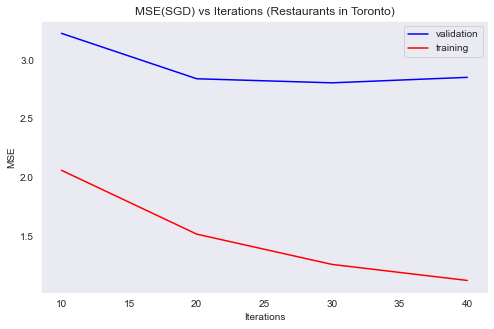

In [118]:
iters = np.arange(10, 50, 10)
err_sgd_test = []
err_sgd_train = []
for i in iters:
    preds_sgd = sgd(np.array(trt_res_train.todense()), k=10, iterations= i)
    err_test = get_mse(preds_sgd[0], np.array( trt_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(trt_res_train.todense()))
    err_sgd_test.append(err_test)
    err_sgd_train.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(iters,err_sgd_test,'b-',label = 'validation')
plt.plot(iters,err_sgd_train,'r-', label = 'training')
plt.title('MSE(SGD) vs Iterations (Restaurants in Toronto)')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

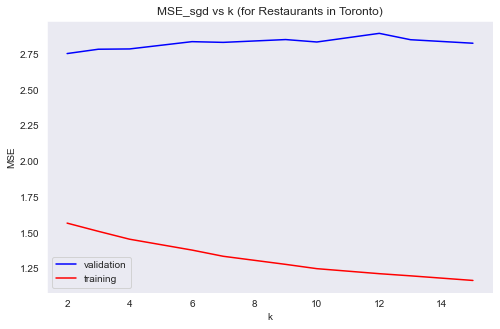

In [119]:
k = np.linspace(2, 15, 10, dtype = int)
err_sgd_val_trt = []
err_sgd_train_trt = []
for i in k:
    preds_sgd = sgd(np.array(trt_res_train.todense()), k=i, iterations= 30)
    err_val = get_mse(preds_sgd[0], np.array(trt_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(trt_res_train.todense()))
    err_sgd_val_trt.append(err_val)
    err_sgd_train_trt.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(k,err_sgd_val_trt,'b-',label = 'validation')
plt.plot(k,err_sgd_train_trt,'r-', label = 'training')
plt.title('MSE_sgd vs k (for Restaurants in Toronto)')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()

In [121]:
predictions_sgd_trt, error_array_sgd_trt, user_vec_sgd_trt, res_vec_sgd_trt = sgd(np.array(trt_res_train.todense()), k=2, iterations= 40)

In [122]:
Best_Val_MSE = get_mse(predictions_sgd_trt, np.array(trt_res_val.todense()))
print('Best Validation MSE for SGD for Restaurants in Toronto= ', Best_Val_MSE)

Best Validation MSE for SGD for Restaurants in Toronto=  2.779624202333833


## Deep Learning

In [123]:
toronto_reviews.user_id, user_code = pd.factorize(toronto_reviews.user_id)
toronto_reviews.business_id, business_code = pd.factorize(toronto_reviews.business_id)

In [137]:
# Splitting into features and response variables
X = toronto_reviews[['user_id', 'business_id']].values
y = toronto_reviews.stars_x.values[:, np.newaxis]
unique_users = toronto_reviews.user_id.unique()
unique_business = toronto_reviews.business_id.unique()
n_users = toronto_reviews.user_id.nunique()
n_business = toronto_reviews.business_id.nunique()
n_factors=50

In [125]:
# Getting the minimum and maximum rating
min_rating = toronto_reviews.stars_x.values.min()
max_rating = toronto_reviews.stars_x.values.max()

In [126]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [127]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [128]:
# Making a function that has the function definition
def Recommender(n_users, n_business, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    business = Input(shape=(1,))
    m = EmbeddingLayer(n_business, n_factors)(business)
    mb = EmbeddingLayer(n_business, 1)(business)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, business], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [129]:
# Making the model
model = Recommender(n_users, n_business, n_factors, min_rating, max_rating)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        2250400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        103050      input_2[0][0]                    
____________________________________________________________________________________________

In [130]:
# Adding EarlyStopping to avoid overfitting
callback = EarlyStopping(patience=2, restore_best_weights=True)

In [131]:
# Training the model
history = model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=10, batch_size=64, validation_data=([X_test[:, 0], X_test[:, 1]], y_test), callbacks=[callback] )

Train on 100692 samples, validate on 11189 samples
Epoch 1/10
100692/100692 [==============================] - 9s 89us/step - loss: 1.8476 - val_loss: 1.6748
Epoch 2/10
100692/100692 [==============================] - 8s 80us/step - loss: 1.3159 - val_loss: 1.5079
Epoch 3/10
100692/100692 [==============================] - 8s 81us/step - loss: 0.7154 - val_loss: 1.4976
Epoch 4/10
100692/100692 [==============================] - 8s 80us/step - loss: 0.3638 - val_loss: 1.5246
Epoch 5/10
100692/100692 [==============================] - 8s 79us/step - loss: 0.2203 - val_loss: 1.5470


In [132]:
# Evaluating the model
model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)

11189/11189 [==============================] - 0s 39us/step


1.4976414167611463

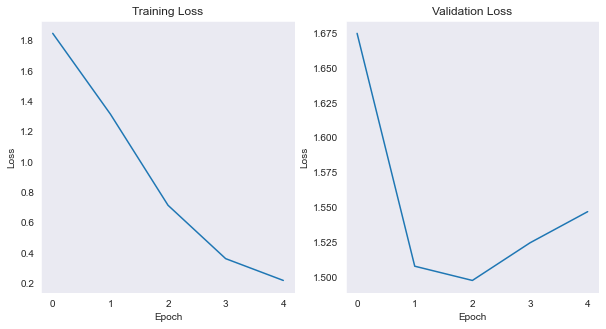

In [154]:
# Plotting the training and validation loss
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("Training Loss")
ax[0].plot(history.history["loss"])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_title("Validation Loss")
ax[1].plot(history.history["val_loss"])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [138]:
# Getting the top 5 predictions
predict_dict = {}
user = np.random.choice(unique_users)
for i in unique_business:

    predict_dict[i] = model.predict([[user], [i]])[0][0]
recommended = sorted(predict_dict.items(), key=lambda x: x[1], reverse=True)[:5]

In [148]:
# getting the business ids of the top 3 predicted codes
reco_b_id = [business_code[i] for i in np.array(recommended, dtype='int')[:,0]]

In [153]:
print(f"top 5 recommended restaurants for user id {user_code[user]} are: \n", [reviews_merged[reviews_merged.business_id==i].name.values[0] for i in reco_b_id])

top 5 recommended restaurants for user id ZqHrkhBX3nKrcYo5u7zfBQ are: 
 ['Pai Northern Thai Kitchen', 'Ramen Isshin', 'Café Polonez', 'Fat Ninja Bite', 'Tango Palace Coffee Company']


In [156]:
reviews_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436131 entries, 0 to 1436130
Columns: 687 entries, review_id to compliment_photos
dtypes: float64(19), int64(603), object(65)
memory usage: 7.4+ GB
